In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

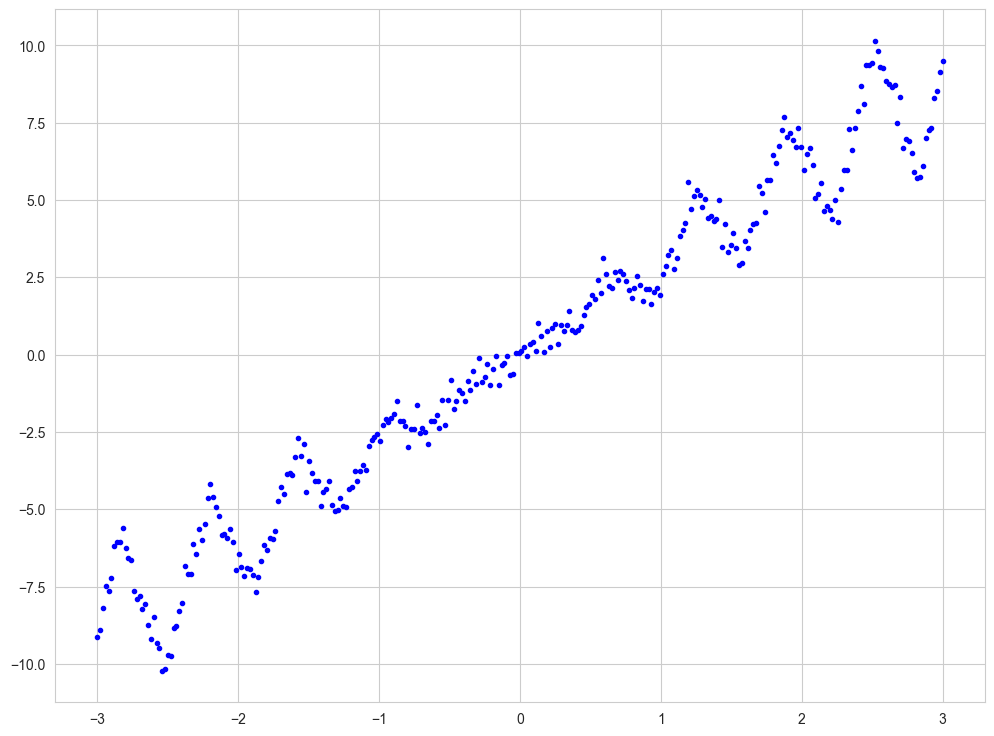

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [4]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

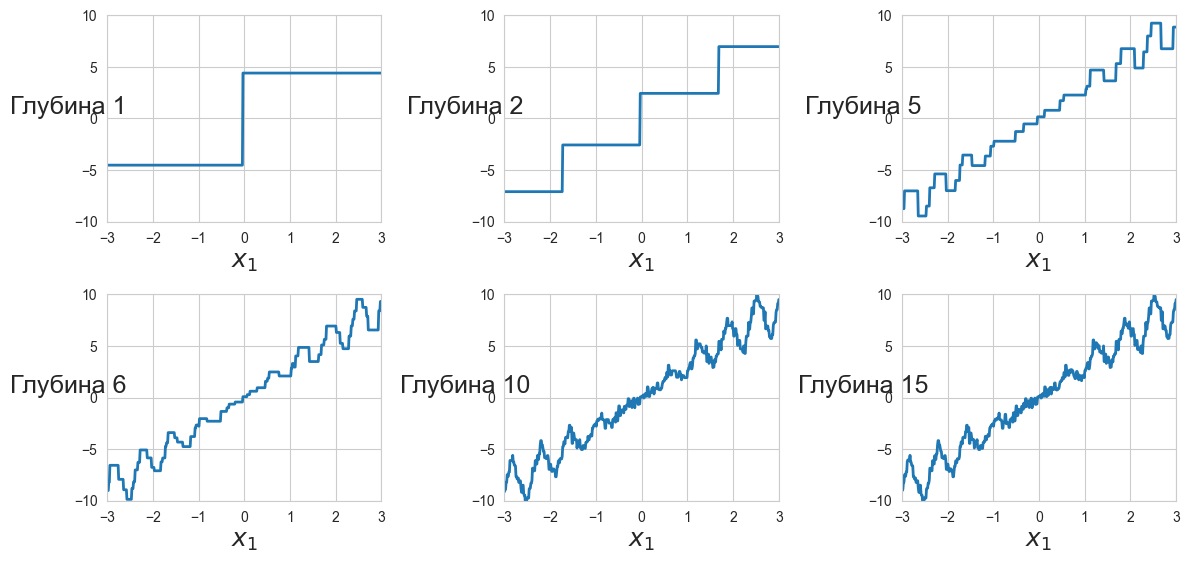

In [5]:

depths = [1, 2, 5, 6, 10,15]

plt.figure(figsize=(12, 8))

for i, depth in enumerate(depths, 1):
    plt.subplot(3, 3, i)
    tree_reg = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree_reg.fit(X, y)
    plot_regression_predictions(tree_reg, X, y, ylabel=("Глубина %d" % depth))

plt.tight_layout()
plt.show()

Кажется, что начиная с глубины 10 наша модель начинает слишком хорошо запоминать исходные данные и переобучаться. На мой взгляд оптимальным значением глубины в данном случае было бы 6.

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [6]:
def expected_accuracy(p):
    mu = sum(np.math.comb(101, i) * p**i * (1-p)**(101-i) for i in range(51, 102))
    return mu

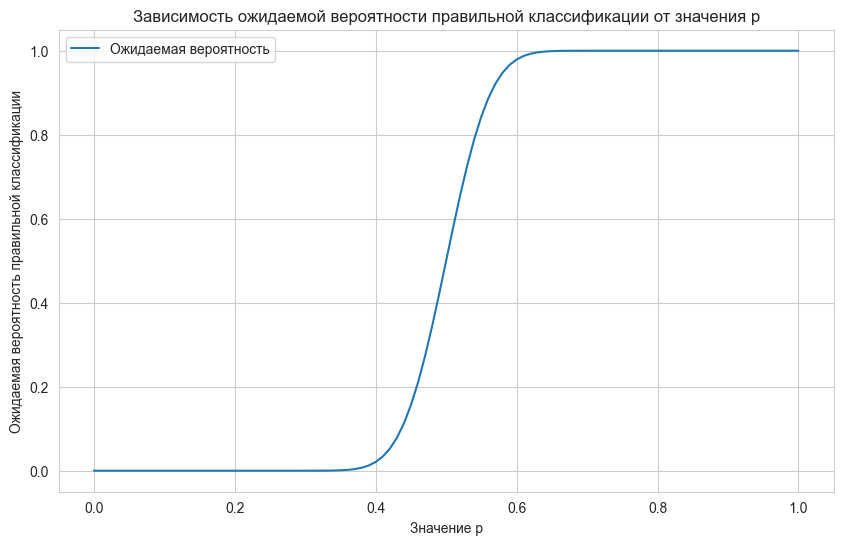

In [7]:
# Значения вероятности p от 0 до 1 с шагом 0.01
p_values = np.linspace(0, 1, 101)

# Вычисляем ожидаемую вероятность правильной классификации для каждого значения p
accuracy_values = [expected_accuracy(p) for p in p_values]

# Строим график
plt.figure(figsize=(10, 6))
plt.plot(p_values, accuracy_values, label='Ожидаемая вероятность')
plt.xlabel('Значение p')
plt.ylabel('Ожидаемая вероятность правильной классификации')
plt.title('Зависимость ожидаемой вероятности правильной классификации от значения p')
plt.grid(True)
plt.legend()
plt.show()

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [8]:
def expected_accuracy_models(n):
    mu = sum(np.math.comb(n, i) * 0.65**i * (1-0.65)**(n-i) for i in range(51, n+1))
    return mu

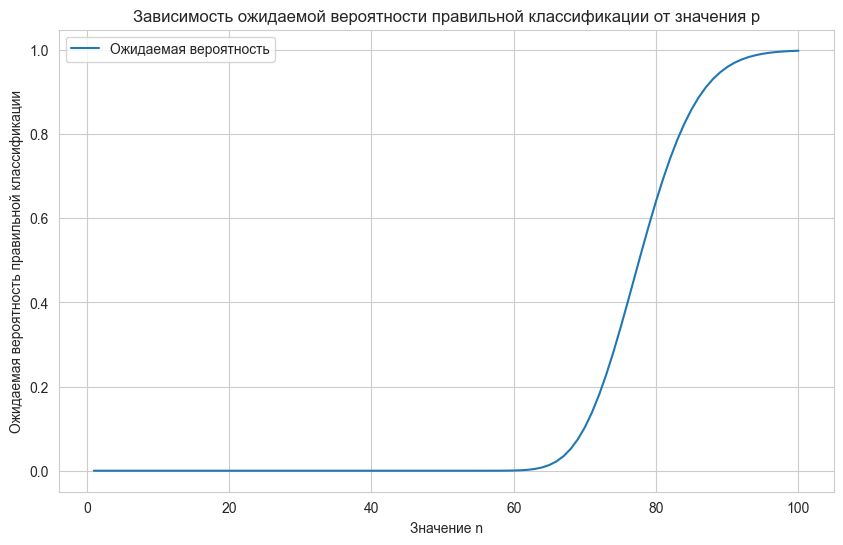

In [9]:

n_values = np.arange(1, 101)


accuracy_values = [expected_accuracy_models(n) for n in n_values]


plt.figure(figsize=(10, 6))
plt.plot(n_values, accuracy_values, label='Ожидаемая вероятность')
plt.xlabel('Значение n')
plt.ylabel('Ожидаемая вероятность правильной классификации')
plt.title('Зависимость ожидаемой вероятности правильной классификации от значения p')
plt.grid(True)
plt.legend()
plt.show()

Опишите ваши наблюдения:

* ожидаемая вероятность правильной классификации увеличивается вместе с вероятностью правильно предсказанного класса объекта, при этом ожидаемая вероятность правильной классификации начинает расти после достижении вероятности модели правильно предсказывать объект значения 0.5
* чем больше моделей в ансамбле, тем выше вероятность правильной классификации, при этом вероятность правильной классификации начинает нормально расти только после достижения 60 моделей в ансамбле

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [10]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))

        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)

            feat_ids = np.random.choice(range(X.shape[1]), size=self.max_features, replace=False)
            self.feat_ids_by_tree.append(feat_ids)

            indices = np.random.choice(range(X.shape[0]), size=X.shape[0], replace=True)
            X_bootstrap, y_bootstrap = X[indices], y[indices]

            tree = DecisionTreeClassifier(max_depth=self.max_depth, random_state=self.random_state)
            tree.fit(X_bootstrap[:, feat_ids], y_bootstrap)
            self.trees.append(tree)

    def predict_proba(self, X):
        probas = np.zeros((X.shape[0], len(self.classes_)))
        
        for i, tree in enumerate(self.trees):
            feat_ids = self.feat_ids_by_tree[i]
            probas += tree.predict_proba(X[:, feat_ids])

        return probas / len(self.trees)
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [11]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

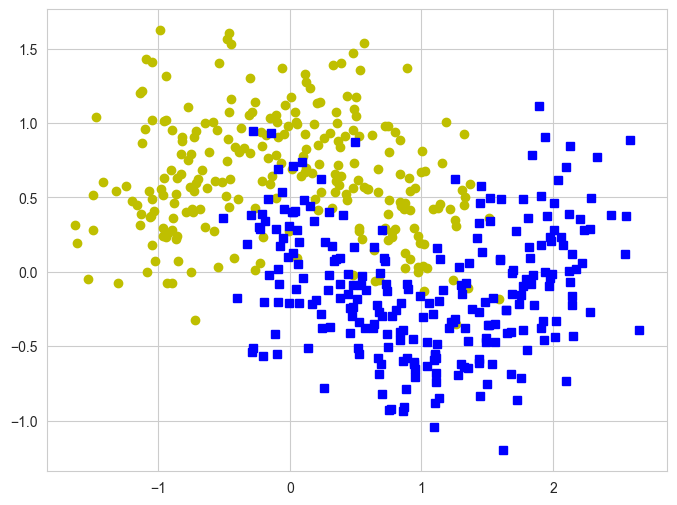

In [12]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [13]:
rf_clf = RandomForestClassifierCustom(n_estimators=10, max_depth=None, max_features= 2, random_state=42)
rf_clf.fit(X, y)

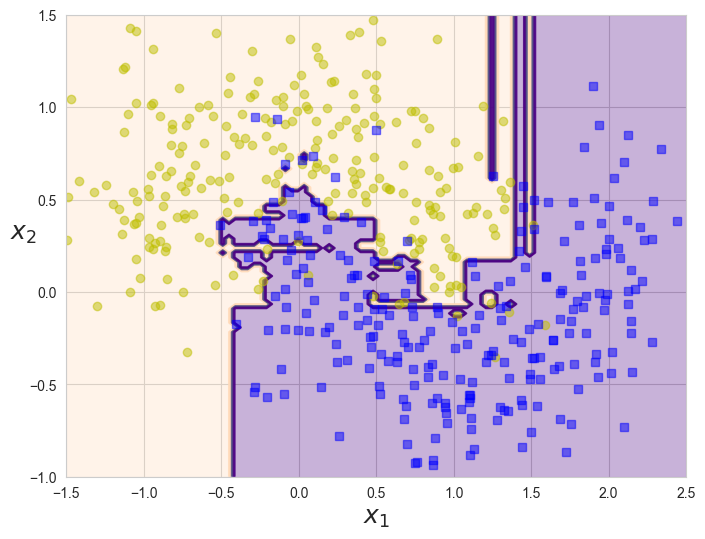

In [14]:
plt.figure(figsize=(8, 6))
plot_decision_boundary(rf_clf, X, y)
plt.show()

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

Для подбора параметров будем использовать GridSearchCV. В качестве метрики качества выберу accuracy, так как я хочу учитывать долю правильных ответов.

In [15]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10],
    'max_features': [2]
}

rf = RandomForestClassifierCustom(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifierCustom(random_state=42),
             param_grid={'max_depth': [None, 5, 10], 'max_features': [2],
                         'n_estimators': [10, 50, 100]},
             scoring='accuracy')

Визуализируем границы лучшей модели:

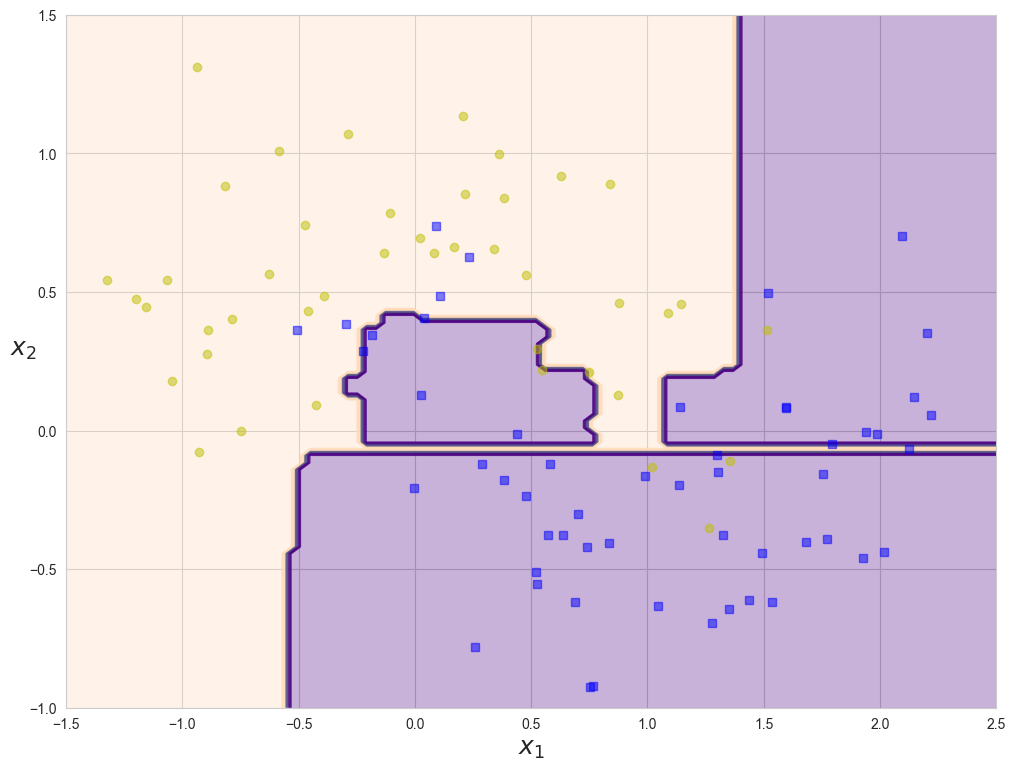

In [18]:
best_model = grid_search.best_estimator_
plot_decision_boundary(best_model, X_test, y_test)
plt.show()

Полученные параметры лучшей модели:

In [19]:
print("Best parameters:", grid_search.best_params_)
print("Test accuracy:", grid_search.best_score_)

Best parameters: {'max_depth': 5, 'max_features': 2, 'n_estimators': 10}
Test accuracy: 0.9349999999999999


#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [20]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [21]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [22]:
max_features_values = [2, 4, 6, 8, 10, 12, 14, 16]

correlation_values = []

for max_features in max_features_values:
    rf_clf = RandomForestClassifier(n_estimators=100, max_features=max_features, random_state=42)
    rf_clf.fit(X_train, y_train)
    
    corrs = base_model_pair_correlation(rf_clf, X_test)
    correlation_values.append(corrs)

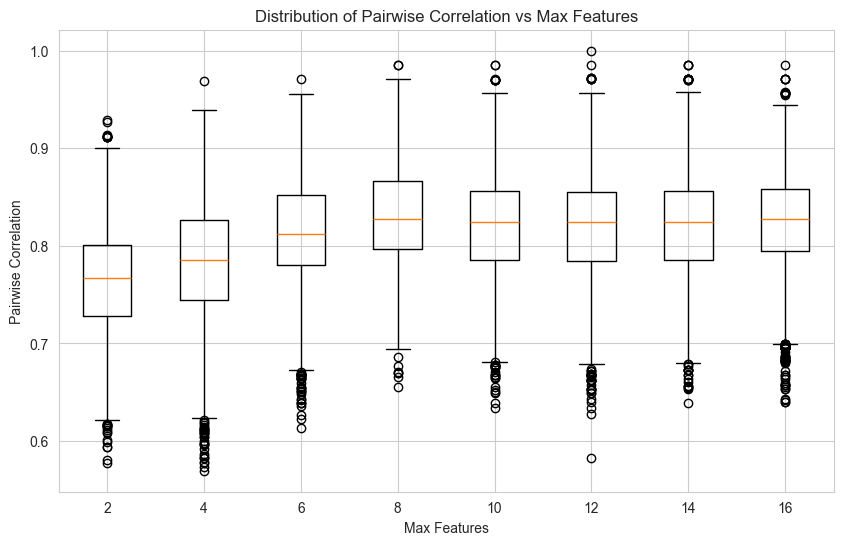

In [23]:
plt.figure(figsize=(10, 6))
plt.boxplot(correlation_values, labels=max_features_values)
plt.xlabel('Max Features')
plt.ylabel('Pairwise Correlation')
plt.title('Distribution of Pairwise Correlation vs Max Features')
plt.grid(True)
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

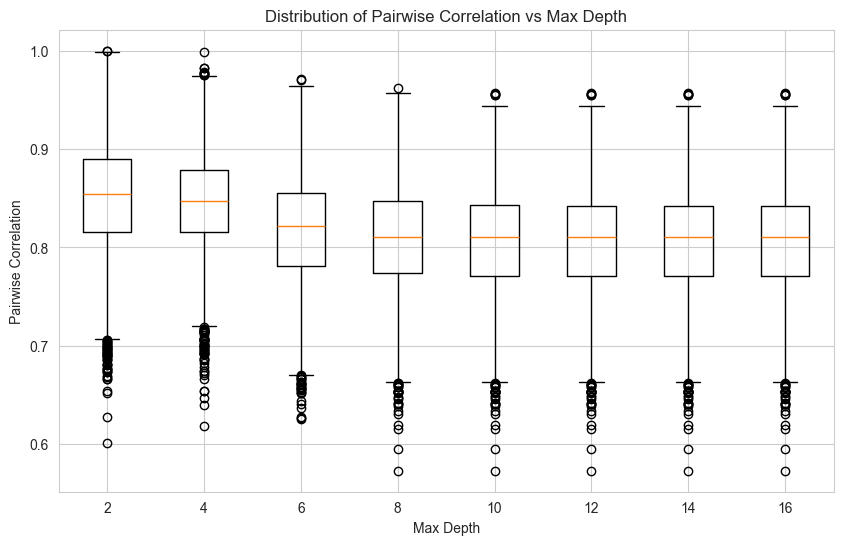

In [24]:
max_depth_values = [2, 4, 6, 8, 10, 12, 14, 16]

correlation_values = []

for max_depth in max_depth_values:
    rf_clf = RandomForestClassifier(n_estimators=100, max_depth=max_depth, random_state=42)
    rf_clf.fit(X_train, y_train)
    
    corrs = base_model_pair_correlation(rf_clf, X_test)
    correlation_values.append(corrs)

plt.figure(figsize=(10, 6))
plt.boxplot(correlation_values, labels=max_depth_values)
plt.xlabel('Max Depth')
plt.ylabel('Pairwise Correlation')
plt.title('Distribution of Pairwise Correlation vs Max Depth')
plt.grid(True)
plt.show()

Опишите ваши наблюдения:

* чем большее число признаков мы используем, тем сильнее коррелируют предсказания моделей между собой
* с увеличением глубины корреляция предсказаний снижается

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [26]:
!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("heart.csv")

In [27]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [28]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [29]:
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting='soft')

models_scores = []
models_names = ['DT', 'RF', 'CAT', 'ETC', 'KNN', 'SVC_LIN', 'SVC_RBF',  'XGB', 'LGBM', 'XGB_RF', 'LGBM_RF', 'LR', 'NB', 'VH', 'VS']

for model, name in zip([dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft], models_names):
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    models_scores.append(f'{model.__class__.__name__} {name}: {scores.mean():.3g}')
    print(f"{model.__class__.__name__}: {scores.mean()}")


DecisionTreeClassifier: 0.797997226792219


RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.8281746031746032
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.8134522115571786
[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore=0.092782
[LightGBM] [Info] Start training from score 0.092782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [30]:
for model in models_scores:
    print(model)

DecisionTreeClassifier DT: 0.798
RandomForestClassifier RF: 0.833
CatBoostClassifier CAT: 0.834
ExtraTreesClassifier ETC: 0.828
KNeighborsClassifier KNN: 0.649
SVC SVC_LIN: 0.84
SVC SVC_RBF: 0.697
XGBClassifier XGB: 0.813
LGBMClassifier LGBM: 0.817
XGBRFClassifier XGB_RF: 0.846
LGBMClassifier LGBM_RF: 0.813
LogisticRegression LR: 0.85
GaussianNB NB: 0.814
VotingClassifier VH: 0.845
VotingClassifier VS: 0.85


Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [31]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

Надо заново обучить VotingClassifier, иначе не находит estimators_

In [32]:
voting_hard = VotingClassifier(estimators=base_models,
                               voting='hard')

voting_hard.fit(X_train, y_train)

pred_voting_hard = voting_hard.predict(X_test)

corr_hard = base_model_pair_correlation_for_voting_clf(voting_hard, X_train)

df_corr_hard = pd.DataFrame(corr_hard, columns=['Model_1', 'Model_2', 'Correlation'])


[LightGBM] [Info] Number of positive: 118, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519824 -> initscore=0.079337
[LightGBM] [Info] Start training from score 0.079337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [34]:
df_corr_hard.head(5)

,Model_1,Model_2,Correlation
0,"DecisionTreeClassifier(max_depth=10, min_sampl...","(DecisionTreeClassifier(max_features='sqrt', r...",0.868209
1,"DecisionTreeClassifier(max_depth=10, min_sampl...","(ExtraTreeClassifier(random_state=481767252), ...",0.802125
2,"DecisionTreeClassifier(max_depth=10, min_sampl...",KNeighborsClassifier(weights='distance'),0.802125
3,"DecisionTreeClassifier(max_depth=10, min_sampl...","SVC(kernel='linear', probability=True, random_...",0.831921
4,"DecisionTreeClassifier(max_depth=10, min_sampl...","SVC(probability=True, random_state=111)",0.540843


In [41]:
df_corr_hard.loc[:, 'Model_1'] = df_corr_hard.Model_1.apply(str)

df_corr_hard.loc[:, 'Model_2'] = df_corr_hard.Model_2.apply(str)

In [36]:
models_names_short = ['DT', 'RF', 'ETC', 'KNN', 'SVC_LIN', 'SVC_RBF', 'CAT', 'LGBM', 'LGBM_RF', 'XGB', 'XGB_RF', 'LR', 'NB']
models_names_df = df_corr_hard.Model_1.unique().tolist()
models_names_df.append('GaussianNB()')
for terrible_name, short_name in zip(models_names_df, models_names_short):
    df_corr_hard.replace(terrible_name, short_name, inplace=True)



In [39]:
def plot_correlation_heatmap(df):
    plt.figure(figsize=(10, 8))
    pivot_df = df.pivot(index="Model_1", columns="Model_2", values="Correlation")
    sns.heatmap(pivot_df, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Корреляция между моделями')
    plt.xlabel('Модель 2')
    plt.ylabel('Модель 1')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


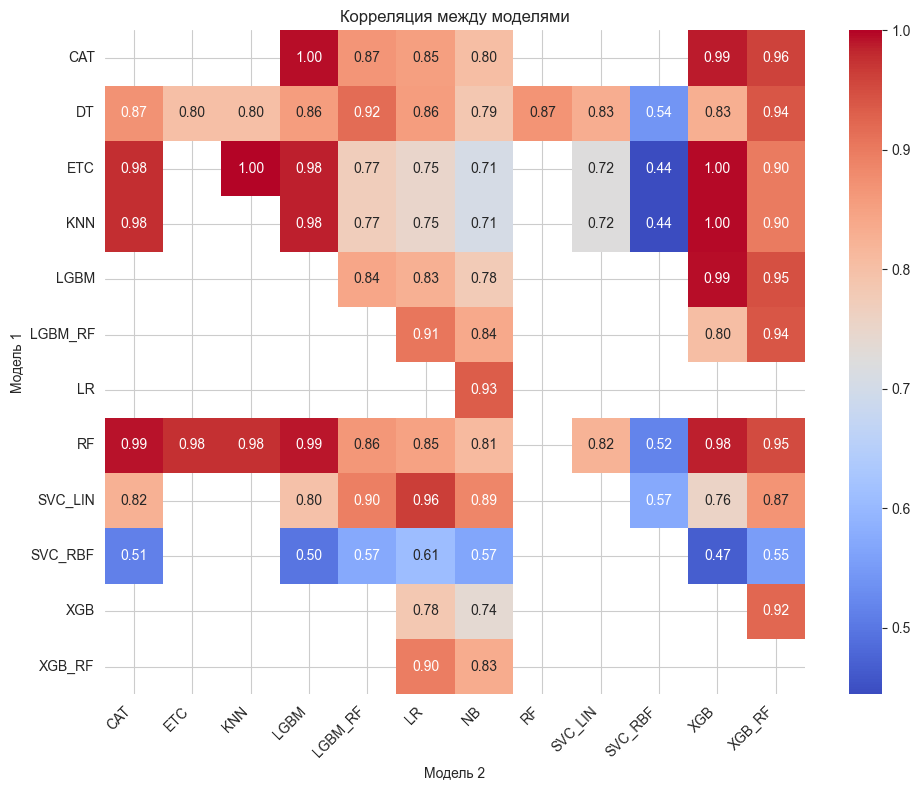

In [40]:
plot_correlation_heatmap(df_corr_hard)

In [78]:
models = [("DT", dt), 
               ("SVC_RBF", svc_rbf), 
               ("LGBM_RF", lgbm_rf), 
               ("LR", lr),
               ("XGB_RF", xgb_rf)]

In [79]:
voting_hard = VotingClassifier(estimators=models,
                               voting='hard')
voting_soft= VotingClassifier(estimators=models,
                               voting='soft')

models_scores = []

for model, name in zip([voting_hard, voting_soft], ['V_hard', 'V_soft']): 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    models_scores.append(f'{name}: {scores.mean():.4g}')

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore=0.092782
[LightGBM] [Info] Start training from score 0.092782
[Li

In [80]:
models_scores

['V_hard: 0.8703', 'V_soft: 0.8486']

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [88]:
data = pd.read_csv("churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


Удалим ненужные признаки:

In [89]:
data.drop(['Phone', 'State'], axis=1, inplace=True)

Проведем EDA:

In [91]:
data.shape

(3333, 19)

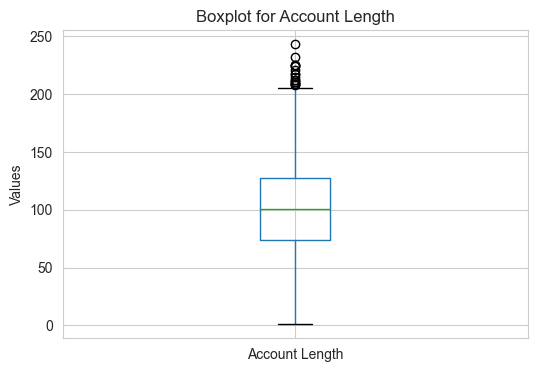

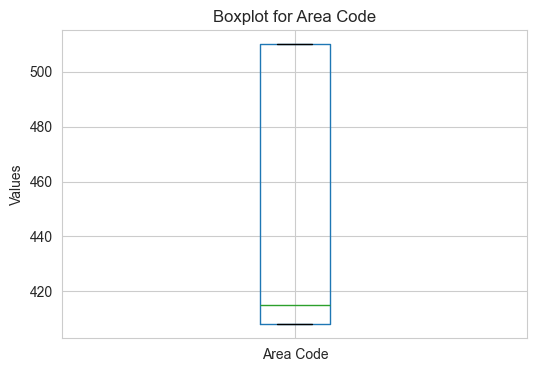

Skipping non-numeric column: Int'l Plan
Skipping non-numeric column: VMail Plan


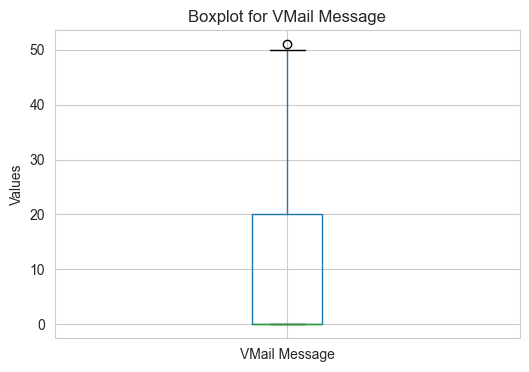

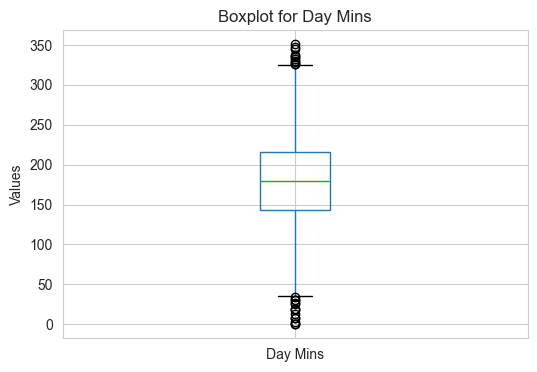

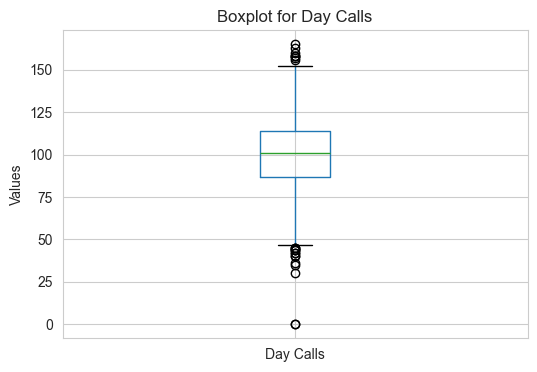

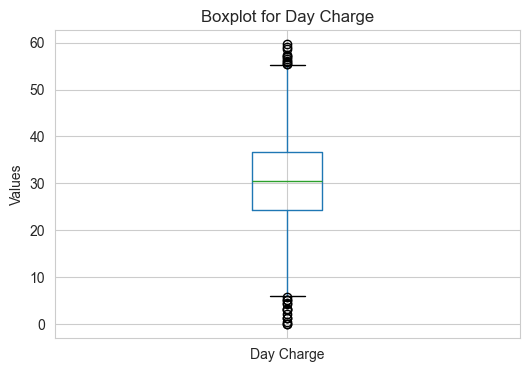

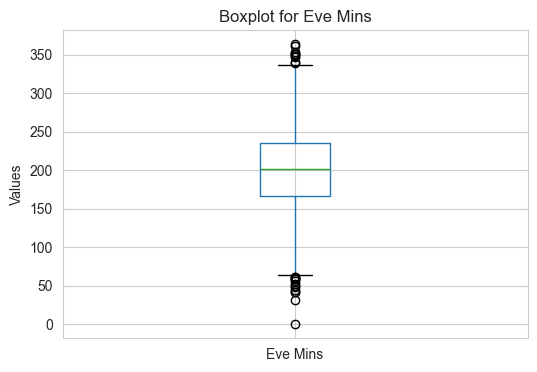

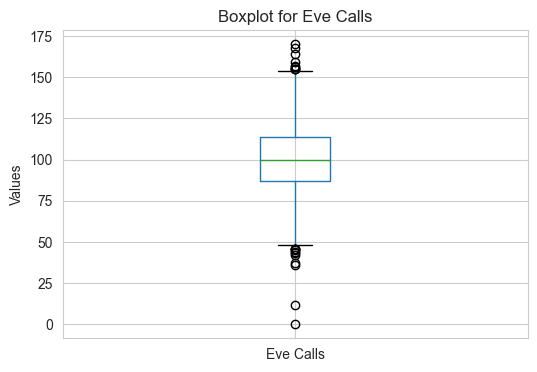

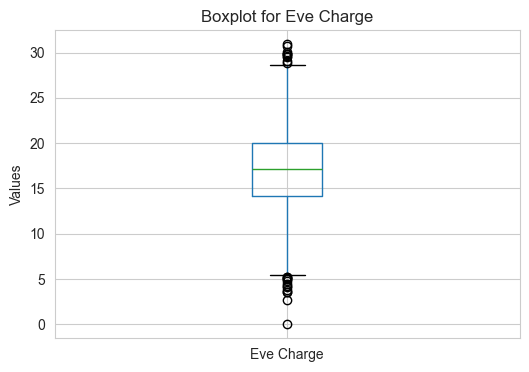

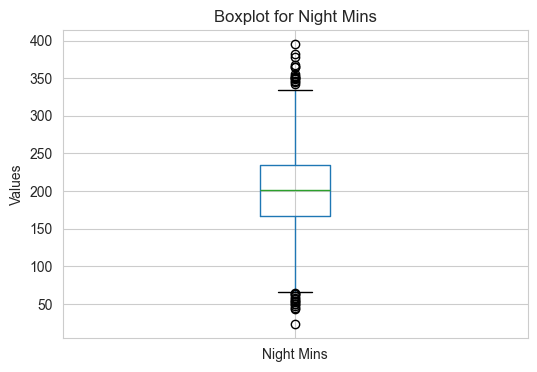

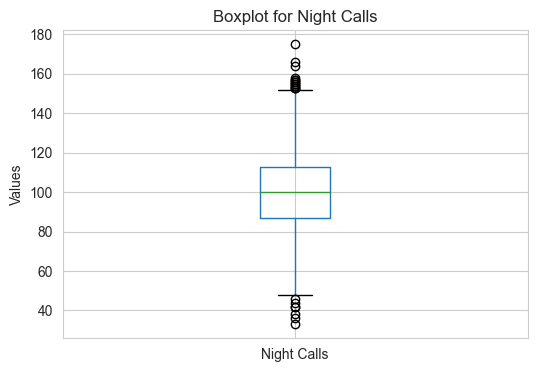

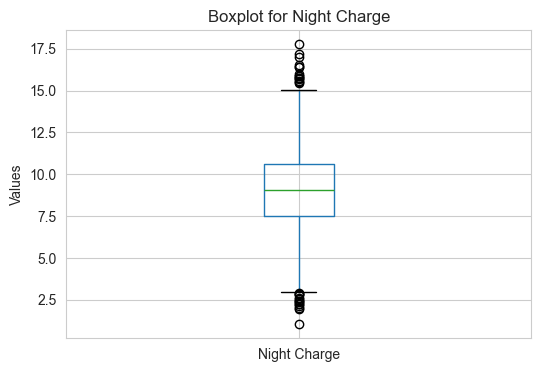

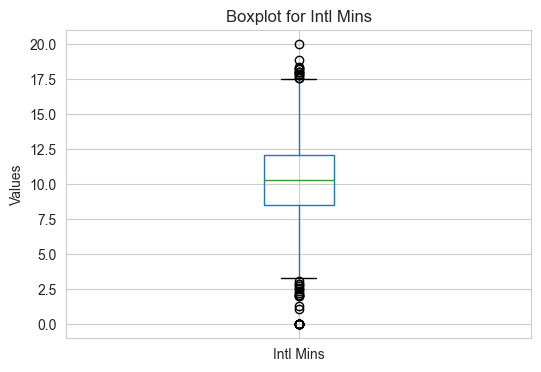

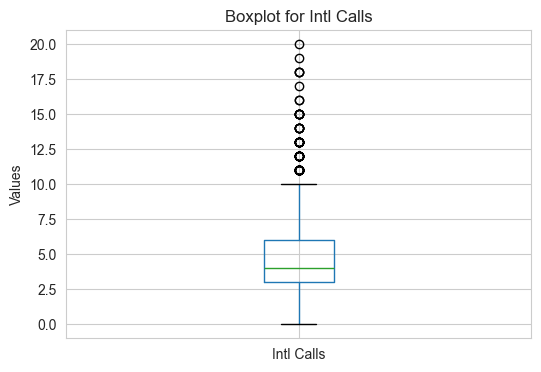

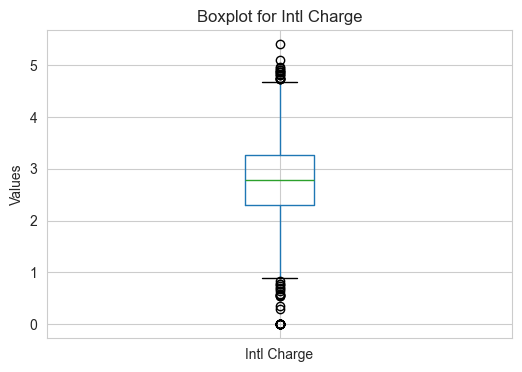

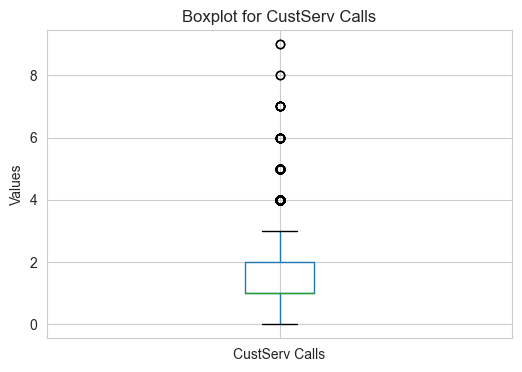

Skipping non-numeric column: Churn?


In [90]:
for column in data.columns:
    if pd.api.types.is_numeric_dtype(data[column]):
        plt.figure(figsize=(6, 4))
        data[[column]].boxplot()

        plt.title(f'Boxplot for {column}')
        plt.ylabel('Values')

        plt.show()
    else:
        print(f"Skipping non-numeric column: {column}")

In [97]:
condition = (data['Account Length'] < 230) & \
            (data['Day Calls'] > 25) & \
            (data['Eve Calls'] > 25) & \
            (data['Eve Charge'] > 25)

data = data[condition]

Преобразуем категориальные признаки:

In [98]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['Int\'l Plan'] = label_encoder.fit_transform(data['Int\'l Plan'])
data['VMail Plan'] = label_encoder.fit_transform(data['VMail Plan'])

Разделим данные на обучающий и тестовый наборы:

In [99]:
X = data.drop('Churn?', axis=1)
y = data['Churn?']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Масштабируем числовые признаки:

In [100]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Настройка гиперпараметров для RandomForestClassifier

In [101]:
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='accuracy')
rf_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [102]:
print("RandomForestClassifier - Best Parameters:", rf_grid_search.best_params_)
print("RandomForestClassifier - Best Cross Validation Score:", rf_grid_search.best_score_)

RandomForestClassifier - Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
RandomForestClassifier - Best Cross Validation Score: 0.8625


In [103]:
# Обучение RandomForestClassifier с наилучшими параметрами
rf_best = rf_grid_search.best_estimator_
rf_best.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=4, n_estimators=200, random_state=42)

In [104]:
# Оценка модели на тестовом наборе данных
from sklearn.metrics import accuracy_score
rf_pred = rf_best.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
print("RandomForestClassifier - Test Accuracy:", rf_accuracy)

RandomForestClassifier - Test Accuracy: 0.9047619047619048


Настройка гиперпараметров для CatBoostClassifier

In [106]:
from catboost import CatBoostClassifier
catboost_param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8]
}

catboost_grid_search = GridSearchCV(CatBoostClassifier(random_state=42, verbose=False), catboost_param_grid, cv=5, scoring='accuracy')
catboost_grid_search.fit(X_train, y_train, verbose=False)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x00000265B9F45960>,
             param_grid={'depth': [4, 6, 8], 'iterations': [100, 200, 300],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='accuracy')

In [107]:
# Вывод наилучших параметров и оценки
print("\nCatBoostClassifier - Best Parameters:", catboost_grid_search.best_params_)
print("CatBoostClassifier - Best Cross Validation Score:", catboost_grid_search.best_score_)


CatBoostClassifier - Best Parameters: {'depth': 4, 'iterations': 100, 'learning_rate': 0.01}
CatBoostClassifier - Best Cross Validation Score: 0.8625


In [108]:
# Обучение CatBoostClassifier с наилучшими параметрами
catboost_best = catboost_grid_search.best_estimator_
catboost_best.fit(X_train, y_train, verbose=False)

In [109]:
# Оценка модели на тестовом наборе данных
catboost_pred = catboost_best.predict(X_test)
catboost_accuracy = accuracy_score(y_test, catboost_pred)
print("CatBoostClassifier - Test Accuracy:", catboost_accuracy)

CatBoostClassifier - Test Accuracy: 0.9047619047619048


Интересно, что обе модели у меня получились согласно метрики одинаковоми.

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [ ]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**